In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from pathlib import Path
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import shape, Point
import math
from sklearn.calibration import calibration_curve
import datetime as dt
from scipy.signal import fftconvolve as scipy_fft_conv
import rasterio
import rasterio.features
import rasterio.warp
import pickle
import json
import warnings
import cv2
import random

random.seed(42)

In [2]:
def train_val_test_split(dataset, testsize, valsize, clustersID):
    test = []
    val = []

    dataset_ = dataset.copy(deep=True)

    def select_rows(prop):
        res = []
        for cluster in clustersID:
            datasetCluster = dataset_[dataset_['cluster'] == cluster].sort_values('creneau').reset_index(drop='True')
            leni = len(datasetCluster)
            limitTestSize = int(leni * prop)
            indexs = []
            i = 0
            while i < limitTestSize:
                index = datasetCluster.sample(1).index[0]
                if index in indexs:
                    continue
                dataset_.drop(index, inplace=True)
                datasetCluster.drop(index, inplace=True)
                startdate = datasetCluster.loc[index]['creneau']
                endate = (dt.strftime(datasetCluster.loc[index]['creneau'], '%Y-%m-%d') + dt.timedelta(days=seq_len)).strptime('%Y-%m-%d')
                t = datasetCluster[(datasetCluster['creneau'] >= startdate) & (datasetCluster['creneau'] <= endate)]
                res.append(t)
                i += 1

        return pd.concat(res).reset_index(drop=True)

    test = select_rows(testsize)
   
    val = select_rows(valsize)

    train = dataset_.reset_index(drop=True)
    return train, val, test

def split_sequences(sequencesX, sequencesY, n_steps):
    X, y = list(), list()
    for i in range(len(sequencesX)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequencesX)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequencesX[i:end_ix, :]
        seq_y = sequencesY[i:end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
from scipy import stats

def freedman_diaconis(data, returnas="bins"):
    """
    Utilise la règle de Freedman Diaconis pour calculer la largeur optimale des bins de l'histogramme.
    ``returnas`` peut être "width" ou "bins", indiquant si la largeur ou le nombre de
    la largeur de l'histogramme ou le nombre d'histogrammes doit être retourné.

    Parameteres
    ----------
    - data: np.ndarray One-dimensional array.
    - returnas : {"width", "bins"}
      Si "width", la largeur estimée de chaque cellule de l'histogramme est renvoyée.
      Si "bins", renvoie le nombre de bins suggéré par rule.ively.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = max(stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit"), np.min(data))
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
       
        result = int((datrng / bw) + 1)
    return result

def expected_calibration_error(y, proba):
    """
    Calcule l'erreur de calibration : expected_calibration_error (ECE)
    """
    bin_count, bin_edges = np.histogram(proba, bins = 'auto')
    n_bins = len(bin_count)
    bin_edges[0] -= 1e-8 # because left edge is not included
    bin_id = np.digitize(proba, bin_edges, right = True) - 1
    bin_ysum = np.bincount(bin_id, weights = y, minlength = n_bins)
    bin_probasum = np.bincount(bin_id, weights = proba, minlength = n_bins)
    bin_ymean = np.divide(bin_ysum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
    bin_probamean = np.divide(bin_probasum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
    ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba) * 100
    return n_bins, ece

In [5]:
version = 'without_2023'

dir_csv = Path(version)

dataset = pd.read_csv(dir_csv / 'dataset_2018_2022_calibrated.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'without_2023/dataset_2018_2022_calibrated.csv'

In [5]:
dataset

,creneau,cluster,temp_0,dwpt_0,rhum_0,prcp_0,wdir_0,wspd_0,prec24h_0,dc_0,...,prec24h_16gradient_top1,prec24h_16gradient_top2,prec24h_16gradient_top3,wspd_16gradient_top1,wspd_16gradient_top2,wspd_16gradient_top3,classNonCalibrated,calibratedProba,classCalibrated,classCalibratedProba
0,2018-01-01,0,7.708195,2.587474,69.904030,2.749812e-03,228.754930,7.166032,2.919980,1.139900,...,0,0,0,0,0,0,0,0.004122,0,0.013058
1,2018-01-01,1,8.499556,2.300593,65.004825,9.429739e-07,150.069710,5.112340,3.697905,1.741527,...,0,0,0,0,0,0,0,0.004032,0,0.013058
2,2018-01-01,2,8.501549,2.299490,64.990662,1.034456e-06,149.827725,5.107520,3.704007,2.386157,...,0,0,0,0,0,0,0,0.003920,0,0.013058
3,2018-01-01,3,8.501886,2.299423,64.988840,2.003175e-06,149.827571,5.106053,3.701773,1.162164,...,0,0,0,0,0,0,0,0.004050,0,0.013058
4,2018-01-01,4,7.757990,2.727478,70.346643,-3.387317e-02,228.433771,7.195435,2.661279,1.126214,...,0,0,0,0,0,0,0,0.004002,0,0.013058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,2022-12-30,245,7.051899,5.193151,88.214834,-2.853576e-02,249.089997,0.863522,15.879420,-8.576618,...,0,0,0,0,0,0,0,0.008794,0,0.013058
36496,2022-12-30,246,7.084041,4.627666,84.560165,8.773922e-02,229.828261,4.464630,17.068193,1.569277,...,0,0,0,0,0,0,0,0.004033,0,0.013058
36497,2022-12-30,247,4.219282,2.411229,87.878212,2.987352e-04,176.046457,4.311260,9.381132,-0.547099,...,0,0,0,0,0,0,0,0.004066,0,0.013058
36498,2022-12-30,248,8.477343,5.172184,80.185120,-1.198848e-02,194.565471,2.140644,13.169174,-6.462538,...,0,0,0,0,0,0,0,0.003920,0,0.013058


In [6]:
if 'osmnx' in dataset.columns:
    dataset.drop('osmnx', axis=1, inplace=True)

dataset['coef'] = 1

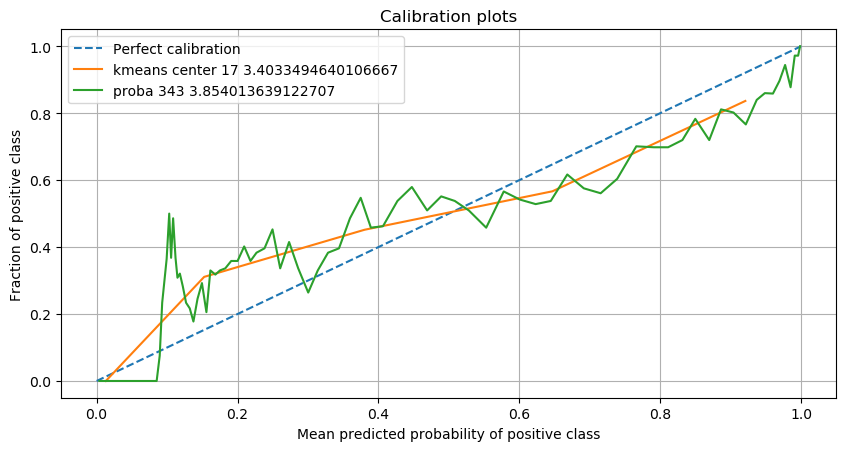

In [7]:
from sklearn.linear_model import LogisticRegression
from matplotlib.gridspec import GridSpec

calibratedProba = dataset['calibratedProba'].values
classCenter = dataset['classCalibratedProba'].values

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
ax_calibration_curve.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
n_bins, ece = expected_calibration_error(dataset['isFire'], classCenter)
y_means, proba_means = calibration_curve(dataset['isFire'], classCenter, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='kmeans center ' + str(n_bins) + " " + str(ece))

n_bins, ece = expected_calibration_error(dataset['isFire'], calibratedProba)
y_means, proba_means = calibration_curve(dataset['isFire'], calibratedProba, n_bins=n_bins, strategy='quantile')
ax_calibration_curve.plot(proba_means, y_means, label='proba ' + str(n_bins) + " " + str(ece))

ax_calibration_curve.set(xlabel="Mean predicted probability of positive class", ylabel="Fraction of positive class")
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")
ax_calibration_curve.legend()

plt.savefig(dir_csv / 'calibration_study.png')

In [8]:

topvariables = [ 'dc_0', 'ffmc_0', 'dmc_0', 'isi_0', 'bui_0', 'fwi_0',
 'nesterov_0', 'munger_0', 'kbdi_0', 'angstroem_0', 'daily_severity_rating_0',
 'temp_0', 'dwpt_0', 'rhum_0', 'prcp_0', 'wdir_0', 'wspd_0', 'prec24h_0',
 'temp16_0', 'dwpt16_0', 'rhum16_0', 'prcp16_0', 'wdir16_0', 'wspd16_0', 'prec24h16_0',
 'days_since_rain_0',
 'dc_mean', 'dmc_mean', 'ffmc_mean', 'isi_mean', 'bui_mean', 'fwi_mean', 'daily_severity_rating_mean', 'temp_mean', 'dwpt_mean', 'rhum_mean', 'prcp_mean', 'prec24h_mean', 'wspd_mean',
 'dc_max','dmc_max', 'ffmc_max', 'isi_max', 'bui_max', 'fwi_max', 'daily_severity_rating_max', 'temp_max', 'dwpt_max', 'rhum_max', 'prcp_max', 'prec24h_max', 'wspd_max',
 'dc_min', 'dmc_min', 'ffmc_min', 'isi_min', 'bui_min', 'fwi_min', 'daily_severity_rating_min',
 'temp_min', 'dwpt_min', 'rhum_min', 'prcp_min', 'prec24h_min', 'wspd_min',
 'temp_gradient','dwpt_gradient', 'rhum_gradient', 'prcp_gradient', 'prec24h_gradient', 'wspd_gradient',
 'temp16_mean', 'dwpt16_mean', 'rhum16_mean', 'prcp16_mean', 'prec24h16_mean', 'wspd16_mean',
 'temp16_max', 'dwpt16_max', 'rhum16_max', 'prcp16_max', 'prec24h16_max', 'wspd16_max',
 'temp16_min', 'dwpt16_min', 'rhum16_min', 'prcp16_min', 'prec24h16_min', 'wspd16_min',
 'temp_16gradient', 'dwpt_16gradient', 'rhum_16gradient', 'prcp_16gradient', 'prec24h_16gradient', 'wspd_16gradient'
]


variables = [  'dc_0', 'ffmc_0', 'dmc_0', 'isi_0', 'bui_0', 'fwi_0',
 'nesterov_0', 'munger_0', 'kbdi_0', 'angstroem_0', 'daily_severity_rating_0',
 'temp_0', 'dwpt_0', 'rhum_0', 'prcp_0', 'wdir_0', 'wspd_0', 'prec24h_0',
 'temp16_0', 'dwpt16_0', 'rhum16_0', 'prcp16_0', 'wdir16_0', 'wspd16_0', 'prec24h16_0',
 'days_since_rain_0',

 'dc_mean', 'dmc_mean', 'ffmc_mean', 'isi_mean', 'bui_mean', 'fwi_mean', 'daily_severity_rating_mean', 'temp_mean', 'dwpt_mean', 'rhum_mean', 'prcp_mean', 'prec24h_mean', 'wspd_mean',
 'dc_max','dmc_max', 'ffmc_max', 'isi_max', 'bui_max', 'fwi_max', 'daily_severity_rating_max', 'temp_max', 'dwpt_max', 'rhum_max', 'prcp_max', 'prec24h_max', 'wspd_max',
 'dc_min', 'dmc_min', 'ffmc_min', 'isi_min', 'bui_min', 'fwi_min', 'daily_severity_rating_min',
 'temp_min', 'dwpt_min', 'rhum_min', 'prcp_min', 'prec24h_min', 'wspd_min',
 'temp_gradient','dwpt_gradient', 'rhum_gradient', 'prcp_gradient', 'prec24h_gradient', 'wspd_gradient',
 'temp16_mean', 'dwpt16_mean', 'rhum16_mean', 'prcp16_mean', 'prec24h16_mean', 'wspd16_mean',
 'temp16_max', 'dwpt16_max', 'rhum16_max', 'prcp16_max', 'prec24h16_max', 'wspd16_max',
 'temp16_min', 'dwpt16_min', 'rhum16_min', 'prcp16_min', 'prec24h16_min', 'wspd16_min',
 'temp_16gradient', 'dwpt_16gradient', 'rhum_16gradient', 'prcp_16gradient', 'prec24h_16gradient', 'wspd_16gradient',

 'month', 'dayofyear', 'dayofweek',

 'population_mean', 'elevation_mean', 'elevation_max', 'elevation_min',
 '0.0','1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0',
 #'NDVI', 'NDMI', 'NDSI', 'NDBI', 'NDWI',
 'NumberOfCities',
 'bankHolidays', 'bankHolidaysEve', 'bankHolidaysEveEve',
 'holidays', 'holidaysEve', 'holidaysEveEve', 'holidaysLastDay', 'holidaysLastLastDay',
 'daylightSavingTime',
 'confinement1', 'confinement2', 'ramadan',
 # 'sunRised', 'moonphase','moonrised', 'moon_distance', 'sun_distance',
 'grippe_inc', 'diarrhee_inc', 'varicelle_inc', 'ira_inc',
 'Radio_flux_10cm', 'SESC_Sunspot_number', 'Sunspot_area',
 'New_regions', 'XrayC', 'XrayM', 'XrayX', 'XrayS',
 'Optical1', 'Optical2', 'Optical3',
 'Canicule',
 'match_LGF1', 'match_CL',
 'match_LGF1-2', 'match_LGF1-4', 'match_LGF1-6',  'match_LGF1-8', 'match_LGF1-10', 'match_LGF1-12',
 'match_CL-2', 'match_CL-4', 'match_CL-6', 'match_CL-8', 'match_CL-10', 'match_CL-12',
 'PM25', 'O3A', 'O3B', 'PM10A', 'PM10B', 'NO2A', 'NO2B',

 ]

for top in ['_top1', '_top2', '_top3']:
    for var in topvariables:
        variables.append(var+top)

In [9]:
print(len(dataset))
dataset.dropna(inplace=True)
print(len(dataset))

36500
36500


### Under sampling

### Train val set

In [50]:
clustersID = dataset.cluster.unique()
lenClusterID = len(clustersID)

seq_len = 31
offset = 7

#sequencesX = dataset[variables].values
#sequencesY = dataset['calibratedProba'].values

#X, y = split_sequences(sequencesX, sequencesY, seq_len)

In [39]:
import datetime as dt

def find_no_fire_dates(start, end):
    start_date = dt.datetime.strptime(start, '%Y-%m-%d').date()
    end_date = dt.datetime.strptime(end, '%Y-%m-%d').date()

    delta = dt.timedelta(days=1)
    date = start_date
    res = []
    while date < end_date:
            #if len(firmsDay) == 0:
            #    res.append(date.strftime("%Y-%m-%d"))
            res.append(date.strftime("%Y-%m-%d"))
            date += delta
    return res

startdate = "2018-01-01"
enddate = "2022-12-31"

dates = find_no_fire_dates(startdate, enddate)
len(dates)

1825

In [43]:
print((len(dates) // seq_len), len(clustersID))
(len(dates) // seq_len) * len(clustersID)

58 20


1160

In [86]:
def train_val_test_split(dataset, testsize, valsize, clustersID, dates, offset):
    train = [[] for i in clustersID]
    test = [[] for i in clustersID]
    val = [[] for i in clustersID]
    indexs = []
    lenDates = len(dates)
    dataset_ = dataset.copy(deep=True)

    datesUsed = [[] for i in clustersID]

    def select_rows(prop, res):
        for j, cluster in enumerate(clustersID):
            datasetCluster = dataset_[dataset_['cluster'] == cluster].sort_values('creneau')
            leni = len(datasetCluster)
            limitTestSize = int(leni * prop)

            i = 0
            while i < limitTestSize:
                print(cluster, i)
                date = random.choice(dates)
                if date in datesUsed:
                    continue
                startDate = (dt.datetime.strptime(date, '%Y-%m-%d') - dt.timedelta(days=offset)).strftime('%Y-%m-%d')
                endDate = (dt.datetime.strptime(date, '%Y-%m-%d') + dt.timedelta(days=offset)).strftime('%Y-%m-%d')
                betweenDate = find_no_fire_dates(startDate, endDate)
                datesUsed[j] += betweenDate
                res[j].append(date)
                i += 1

        return res

    test = select_rows(testsize, test)
   
    val = select_rows(valsize, val)

    train = select_rows(1 - testsize - valsize, train)

    return train, val, test

In [87]:
train, val, test = train_val_test_split(dataset, 0.15, 0.2, clustersID, dates, offset)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


In [88]:
len(dates) - (len(train[0]) + len(val[0]) + len(test[0]))

1

In [89]:
for t in train:
    print(t)

['2021-03-08', '2018-09-29', '2020-10-08', '2018-06-25', '2021-02-02', '2019-12-19', '2019-12-27', '2022-02-17', '2018-05-27', '2019-04-16', '2020-08-14', '2018-04-22', '2019-03-04', '2021-12-10', '2019-12-21', '2021-12-26', '2022-07-12', '2022-02-17', '2021-04-05', '2020-07-14', '2022-12-24', '2022-10-01', '2021-05-12', '2020-07-25', '2022-11-11', '2022-09-06', '2021-01-15', '2022-02-09', '2018-02-03', '2021-02-18', '2020-10-09', '2020-11-02', '2021-07-22', '2022-12-05', '2019-08-17', '2018-07-25', '2020-07-26', '2020-11-14', '2020-05-06', '2020-08-23', '2021-06-18', '2021-08-23', '2022-05-22', '2019-04-04', '2021-06-15', '2022-04-18', '2019-03-18', '2020-06-10', '2021-05-05', '2019-03-27', '2021-03-15', '2019-09-09', '2022-02-20', '2022-03-15', '2022-12-13', '2021-05-03', '2021-04-15', '2021-09-20', '2019-11-06', '2022-07-18', '2020-10-04', '2019-01-15', '2018-03-03', '2018-09-26', '2018-04-16', '2019-02-26', '2019-10-11', '2018-12-01', '2018-09-06', '2018-05-07', '2019-09-12', '2021

In [90]:
for t in val:
    print(t)

['2020-08-27', '2021-06-20', '2022-06-11', '2020-03-19', '2018-07-07', '2019-09-27', '2019-06-21', '2019-08-31', '2018-02-17', '2018-05-04', '2019-11-05', '2020-07-26', '2021-04-11', '2021-03-11', '2020-09-25', '2021-05-23', '2021-01-28', '2019-09-13', '2019-03-28', '2018-06-19', '2022-12-11', '2019-11-30', '2018-12-18', '2018-11-30', '2020-09-20', '2021-12-26', '2021-06-27', '2018-06-22', '2018-08-14', '2018-01-27', '2021-10-21', '2020-08-12', '2019-09-17', '2020-06-09', '2019-12-20', '2019-11-30', '2018-03-24', '2020-04-11', '2020-01-27', '2022-04-13', '2022-08-22', '2019-04-30', '2018-01-20', '2019-01-03', '2021-09-01', '2022-11-10', '2018-01-14', '2018-02-22', '2020-05-17', '2021-01-05', '2022-03-14', '2020-04-09', '2022-06-08', '2019-12-12', '2021-08-27', '2018-11-30', '2019-01-22', '2018-11-17', '2018-04-14', '2019-09-14', '2018-10-06', '2022-09-04', '2018-02-15', '2021-08-07', '2019-08-15', '2018-11-24', '2018-10-31', '2022-12-19', '2019-07-25', '2020-08-10', '2022-08-17', '2018

In [91]:
for t in test:
    print(t)

['2022-03-04', '2021-03-22', '2021-12-24', '2018-10-21', '2019-08-15', '2022-02-07', '2022-11-04', '2021-09-12', '2018-10-19', '2019-07-28', '2018-08-13', '2022-07-22', '2022-10-07', '2018-12-16', '2021-05-12', '2020-06-14', '2019-04-09', '2019-12-31', '2022-07-19', '2021-05-18', '2020-10-05', '2020-01-29', '2018-11-26', '2018-10-09', '2020-11-16', '2021-11-26', '2020-11-06', '2019-04-12', '2018-11-02', '2018-03-05', '2022-04-08', '2021-06-22', '2019-03-28', '2021-04-20', '2020-09-30', '2022-04-23', '2019-06-21', '2021-06-19', '2021-01-25', '2018-03-15', '2022-08-02', '2018-02-24', '2022-08-10', '2022-06-04', '2021-05-26', '2018-12-27', '2021-06-05', '2019-04-18', '2020-04-14', '2020-06-25', '2020-06-17', '2020-12-28', '2020-01-24', '2022-08-28', '2018-06-19', '2019-07-19', '2019-12-17', '2019-12-05', '2019-07-07', '2022-04-27', '2022-02-14', '2021-05-01', '2019-10-01', '2019-08-05', '2019-07-14', '2022-02-10', '2019-09-19', '2018-10-16', '2022-05-27', '2021-05-14', '2021-08-15', '2020

###